<a href="https://colab.research.google.com/github/danielgaskins/adversarial-attack-on-vlm-applied-to-google-lens/blob/main/adversarial_attack_on_vlm_applied_to_google_lens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction to Adversarial Attacks on Vision-Language Models

Adversarial attacks in machine learning aim to create small, often human-imperceptible, perturbations to an input (like an image) that cause a model to produce an incorrect output. While traditional attacks targeted classifiers (e.g., making a "cat" image be classified as "car"), the rise of Vision-Language Models like CLIP and its robust variant FARE presents a new frontier. Here, the goal is to alter an image so that the model believes it matches an arbitrary, incorrect text description (e.g., making an image of a "dresser" match the text "a photo of a dog").

The provided scripts demonstrate two powerful methods for achieving this against the FARE model: a **Global Unmasked Attack** and a **Targeted Masked Attack**. Both leverage the **Projected Gradient Descent (PGD)** algorithm, a foundational technique in this field.

### The Mathematical Foundation: Projected Gradient Descent (PGD)

PGD is an iterative method for finding an optimal adversarial perturbation. The core idea is to repeatedly take small steps in the direction that most increases the model's error, while ensuring the perturbation remains "small" and the resulting image is valid.

Let:
-   **$x_{orig}$**: The original, clean image tensor with pixel values in `[0, 1]`.
-   **$x_{adv}$**: The adversarial image tensor we are crafting.
-   **$y_{orig}$**: The text prompt for the original image (e.g., "a photo of a dresser").
-   **$y_{adv}$**: The target adversarial text prompt (e.g., "a photo of a dog").
-   **$f(\cdot)$**: The model (FARE), which outputs feature embeddings. $f_{img}(x)$ is the image embedding and $f_{txt}(y)$ is the text embedding.
-   **$L(\theta, x, y)$**: A loss function we want to maximize. In our case, we want to maximize the similarity between the adversarial image and the adversarial text while minimizing its similarity to the original text.

A common and effective loss function, as used in the code, is the **logit difference loss**:

$L(x_{adv}, y_{orig}, y_{adv}) = \text{sim}(f_{img}(x_{adv}), f_{txt}(y_{adv})) - \text{sim}(f_{img}(x_{adv}), f_{txt}(y_{orig}))$

Here, $\text{sim}(a, b) = a \cdot b^T$ is the cosine similarity (or dot product of normalized features), which the model uses to generate logits. Our goal is to find a perturbation $\delta$ such that $x_{adv} = x_{orig} + \delta$ maximizes this loss. Maximizing this is equivalent to minimizing its negative, which is what the code does: `loss = logit_orig - logit_adv`.

The PGD algorithm proceeds in a loop for $N$ iterations:

1.  **Calculate Gradient**: Compute the gradient of the loss with respect to the input image: $g_t = \nabla_{x_{adv}^{(t)}} L(x_{adv}^{(t)}, ...)$
2.  **Ascend the Gradient**: Update the image by taking a step in the direction of the gradient. $\alpha$ is the step size.
    $x_{adv}^{(t+1)} = x_{adv}^{(t)} + \alpha \cdot \text{sign}(g_t)$
    *(Note: The code does subtraction because it minimizes the negative loss, which is mathematically equivalent).*
3.  **Project into $\epsilon$-ball**: Ensure the total perturbation $\delta = x_{adv}^{(t+1)} - x_{orig}$ does not exceed a predefined budget $\epsilon$. This is typically done using the $L_{\infty}$ norm, which means no single pixel's change can exceed $\epsilon$.
    $\delta = \text{clamp}(\delta, -\epsilon, \epsilon)$
    $x_{adv}^{(t+1)} = x_{orig} + \delta$
4.  **Clip to Valid Range**: Ensure all pixel values of the resulting image remain in the valid `[0, 1]` range.
    $x_{adv}^{(t+1)} = \text{clamp}(x_{adv}^{(t+1)}, 0, 1)$

This iterative process fine-tunes a perturbation that is both effective at fooling the model and constrained to be subtle.


### Attack 1: The Unmasked (Global) Attack

This is the classic implementation of PGD. The perturbation is allowed to modify **any and all pixels** in the image, constrained only by the overall budget $\epsilon$.

**How the `unmasked` code implements this:**

1.  **High-Resolution Attack**: A key feature of this script is that it optimizes the full-resolution image (`x_adv_highres`). It then *differentiates through the model's standard pre-processing steps* (resizing and center-cropping). This is crucial because the attack is optimized for what the model *actually sees* after pre-processing, making it significantly more effective than attacking a pre-shrunk 224x224 image.

2.  **PGD Loop**: The `pgd_attack_high_res` function directly implements the PGD steps described above.
    -   `loss.backward()`: Calculates the gradient ($g_t$).
    -   `x_adv_highres.data = x_adv_highres.data - alpha * grad_sign`: Performs the gradient ascent/descent step.
    -   `eta = torch.clamp(x_adv_highres.data - x_orig_highres.data, min=-epsilon, max=epsilon)`: This is the projection step (Step 3), ensuring the perturbation `eta` is within the $\epsilon$-ball.
    -   `x_adv_highres.data = torch.clamp(x_orig_highres.data + eta, min=0, max=1)`: Applies the projected perturbation and clips the final image to a valid range (Step 4).

**Strengths & Weaknesses:**
*   **Strength**: Highly effective. By using the entire image, it has the maximum possible "surface area" to inject the adversarial signal.
*   **Weakness**: Changes the subject significantly. The perturbation, though small per-pixel, is spread globally. This has a tendancy introduce subtle but noticeable artifacts across the entire image, including the main subject.

--- Adversarial Attack Results ---

Original Image:


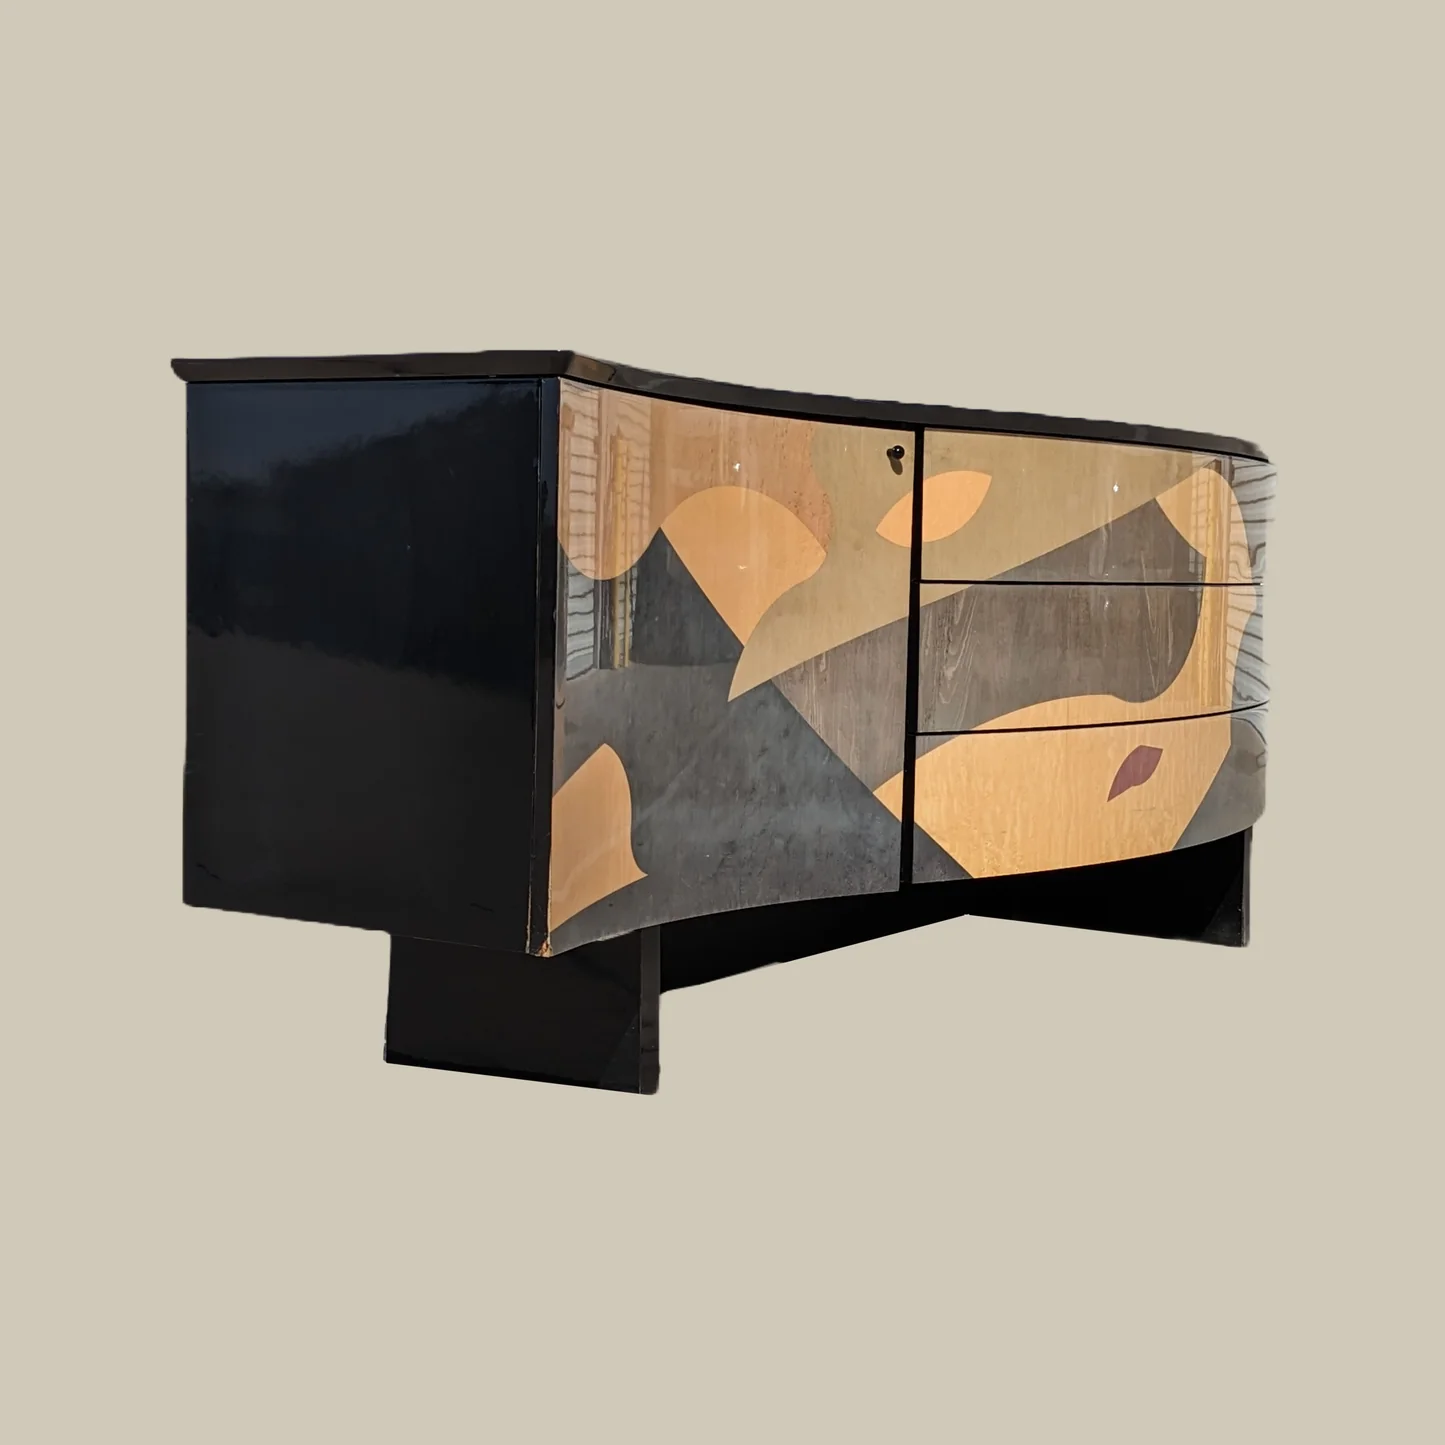


Adversarial Image (Full Resolution - perturbation is nearly invisible):


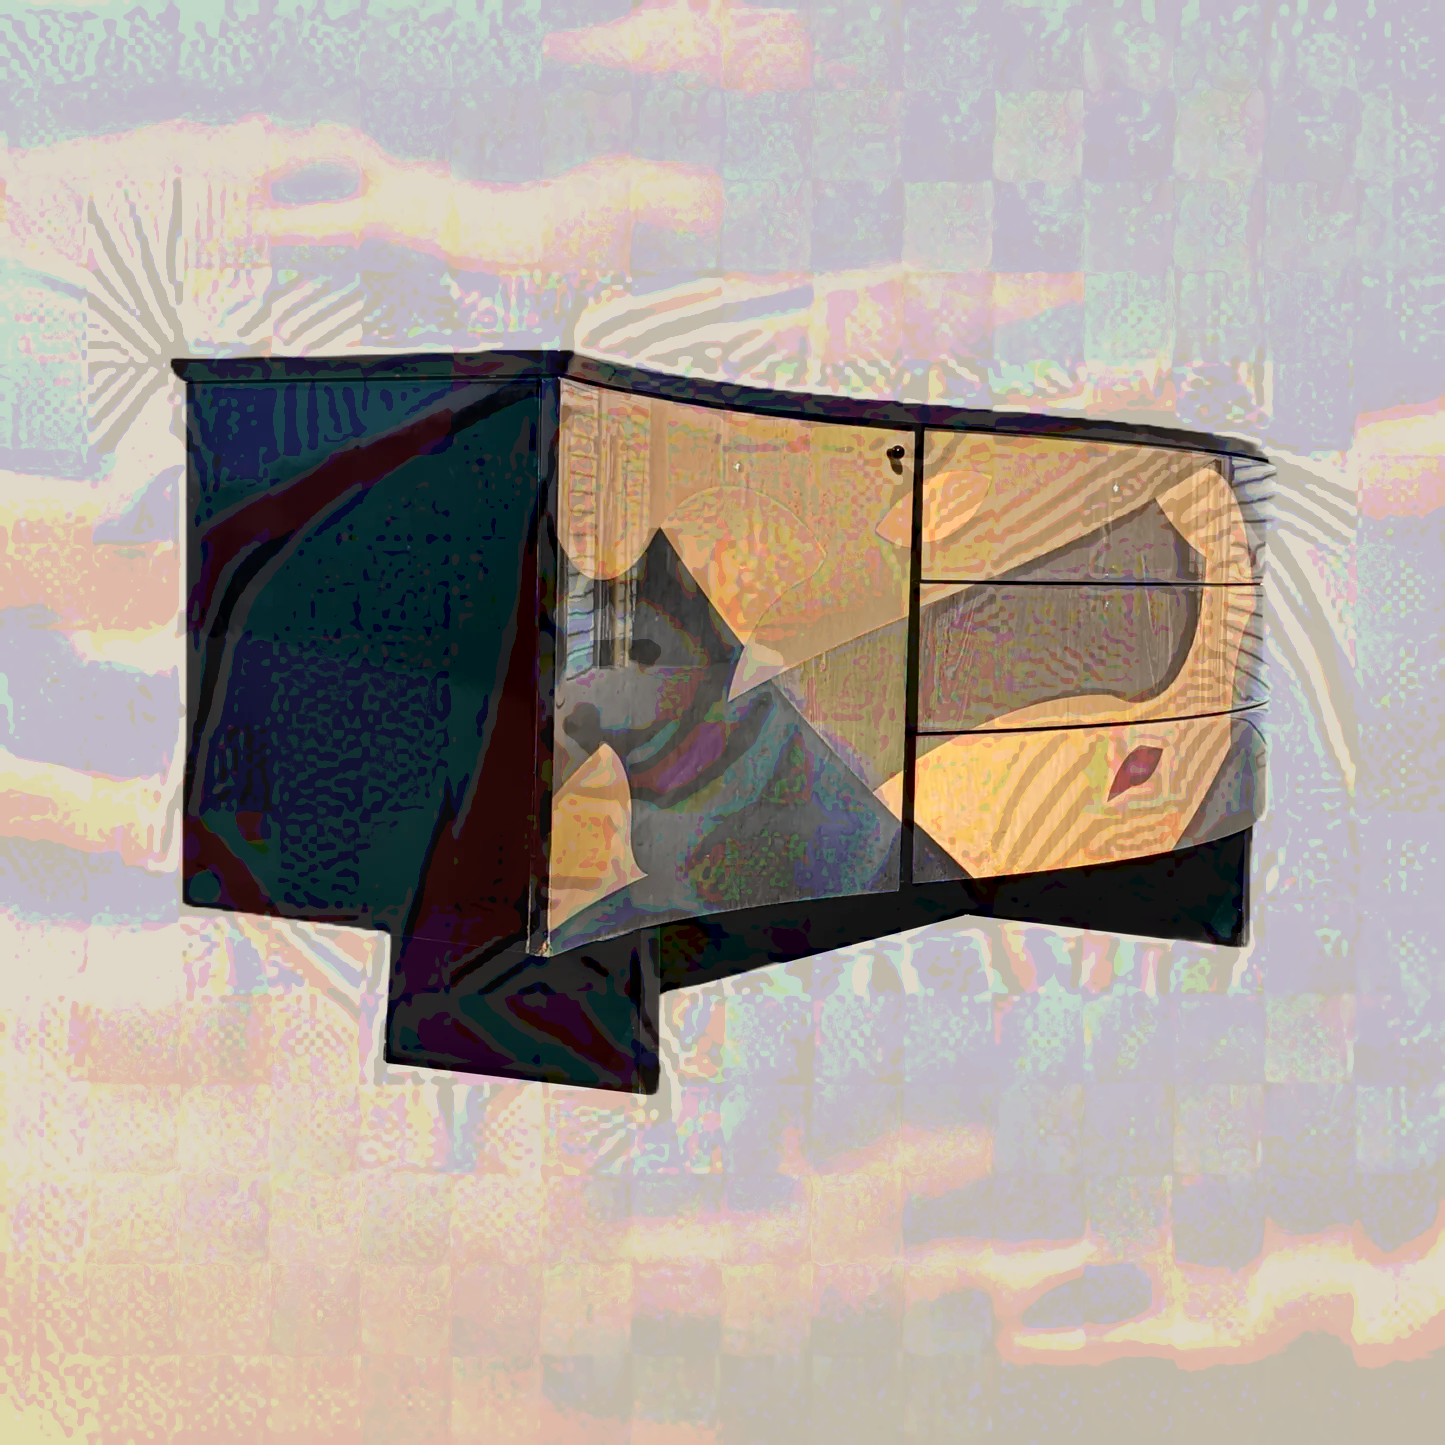


--- FARE Model's Predictions ---

**Predictions for Original Image:**
- 'a photo of a dresser, credenza': 100.00%
- 'a photo of a dog': 0.00%

**Predictions for High-Resolution Adversarial Image:**
-> The model is now fooled by the full-size image!
- 'a photo of a dresser, credenza': 0.00%
- 'a photo of a dog': 100.00%

Adversarial image saved as 'adversarial_image_highres.png'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# Install necessary libraries in Colab
!pip install open_clip_torch torch torchvision Pillow ftfy regex tqdm -q

import torch
import torch.nn.functional as F
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, ToPILImage
import torchvision.transforms.functional as TF # For differentiable transforms
import open_clip
import numpy as np
import io
from google.colab import files
from IPython.display import Image as DisplayImage, display, clear_output

# Set up the device (GPU if available, otherwise CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Helper Function to Split open_clip's Image Processor ---
def split_transforms(processor):
    pre_norm_transforms_list = []
    normalize_params = None
    input_size = None
    for t in processor.transforms:
        if isinstance(t, Normalize):
            normalize_params = {'mean': t.mean, 'std': t.std}
        else:
            if isinstance(t, Resize):
                # In open_clip, this is usually an int, e.g., 224
                # It means resize the smaller edge to this size.
                input_size = t.size
            pre_norm_transforms_list.append(t)
    return Compose(pre_norm_transforms_list), normalize_params, input_size

# --- Model Loading Function ---
def load_fare_model():
    model_id = 'hf-hub:chs20/fare4-clip'
    model, _, image_processor_transforms = open_clip.create_model_and_transforms(model_id)
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    model.to(device).eval()
    pre_norm_processor, normalize_params, input_size = split_transforms(image_processor_transforms)
    return model, pre_norm_processor, normalize_params, tokenizer, input_size

# --- NEW: PGD Attack for High-Resolution Images ---
def pgd_attack_high_res(model, normalize_params, tokenizer, original_pil_image, original_text, adversary_text, model_input_size=224, epsilon=16/255, alpha=2/255, num_iter=40):
    """
    Performs PGD attack by optimizing the high-resolution image directly,
    and differentiating through the pre-processing pipeline (resize, crop).
    """
    # 1. Start with the original image as a full-resolution tensor in [0,1]
    x_orig_highres = TF.to_tensor(original_pil_image).unsqueeze(0).to(device)

    # 2. This is the high-resolution tensor we will perturb
    x_adv_highres = x_orig_highres.clone().detach().requires_grad_(True)

    # 3. Encode text features once
    with torch.no_grad():
        text_features = model.encode_text(tokenizer([original_text, adversary_text]).to(device))
        text_features_orig = text_features[0].unsqueeze(0)
        text_features_adv = text_features[1].unsqueeze(0)

    print("  Starting high-resolution attack loop...")
    for i in range(num_iter):
        # --- Differentiable Pre-processing Pipeline ---
        # a. Resize the smaller edge to `model_input_size` (e.g., 224).
        #    NOTE: F.resize expects (..., H, W) and size can be an int.
        _, _, H, W = x_adv_highres.shape
        if H < W:
            new_h = model_input_size
            new_w = int(model_input_size * W / H)
        else:
            new_w = model_input_size
            new_h = int(model_input_size * H / W)

        x_resized = TF.resize(x_adv_highres, size=[new_h, new_w], interpolation=TF.InterpolationMode.BICUBIC)

        # b. Center crop to the final model input size
        x_cropped = TF.center_crop(x_resized, output_size=[model_input_size, model_input_size])

        # c. Normalize the cropped tensor for the model
        x_model_input = TF.normalize(x_cropped, mean=normalize_params['mean'], std=normalize_params['std'])
        # --- End of Differentiable Pre-processing ---

        # 4. Get image features from the model
        image_features = model.encode_image(x_model_input)

        # 5. Calculate loss (logit-based is often stronger)
        logits = image_features @ text_features.T * 100.0
        loss = logits[0, 0] - logits[0, 1] # Minimize (logit_orig - logit_adv)

        # 6. Backpropagate gradients to the HIGH-RESOLUTION tensor
        model.zero_grad()
        loss.backward()

        # 7. PGD update step on the high-resolution tensor
        grad_sign = x_adv_highres.grad.sign()
        x_adv_highres.data = x_adv_highres.data - alpha * grad_sign # Use minus because we want to MINIMIZE the loss

        # 8. Project perturbation back to the epsilon-ball
        eta = torch.clamp(x_adv_highres.data - x_orig_highres.data, min=-epsilon, max=epsilon)

        # 9. Apply projected perturbation and clamp to valid [0,1] range
        x_adv_highres.data = torch.clamp(x_orig_highres.data + eta, min=0, max=1)
        x_adv_highres.grad.zero_() # Clear gradients for the next iteration

        if (i+1) % 10 == 0 or i == 0 or i == num_iter - 1:
            print(f"    Iteration {i+1}/{num_iter}, Loss: {loss.item():.4f}")

    print("  Attack finished.")
    return x_adv_highres.detach() # Return the final high-resolution perturbed tensor

# --- Similarity Score Calculation Function (Unchanged) ---
def get_similarity_scores(model, pre_norm_processor, normalize_params, tokenizer, image_pil, text_options):
    # This function now takes a PIL image and applies the standard processor
    image_tensor_01 = pre_norm_processor(image_pil).unsqueeze(0).to(device)
    image_model_input = TF.normalize(image_tensor_01, mean=normalize_params['mean'], std=normalize_params['std'])

    with torch.no_grad():
        image_features = model.encode_image(image_model_input)
        text_features = model.encode_text(tokenizer(text_options).to(device))
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity_logits = (100.0 * image_features @ text_features.T)
        similarity_probs = similarity_logits.softmax(dim=-1)

    return similarity_probs.cpu().numpy()

# --- Main Execution for Colab Notebook ---
if __name__ == "__main__":
    print("Loading FARE model...")
    model, pre_norm_processor, normalize_params, tokenizer, model_input_size = load_fare_model()
    print("FARE model loaded successfully!")

    print("\n--- Upload your image ---")
    uploaded = files.upload()

    image_bytes_content = None
    for filename, content in uploaded.items():
        image_bytes_content = content
        print(f"Uploaded '{filename}'")
        break

    if image_bytes_content:
        original_pil_image = Image.open(io.BytesIO(image_bytes_content)).convert("RGB")

        clear_output(wait=True)
        print("--- Original Image ---")
        display(DisplayImage(data=image_bytes_content, width=384))

        original_text = "a photo of a dresser, credenza"
        adversary_text = "a photo of a dog"

        print("\nInitiating HIGH-RESOLUTION adversarial attack...")

        # Perform the high-resolution PGD attack
        adversarial_highres_tensor = pgd_attack_high_res(
            model, normalize_params, tokenizer,
            original_pil_image, original_text, adversary_text,
            model_input_size=model_input_size,
            epsilon=16/255, # Increased epsilon for robust model
            alpha=2/255,
            num_iter=400      # Increased iterations
        )

        # Convert the resulting high-res tensor back to a PIL Image for display and evaluation
        adversarial_pil_image_highres = ToPILImage()(adversarial_highres_tensor.squeeze(0).cpu())

        clear_output(wait=True)

        print("--- Adversarial Attack Results ---")
        print("\nOriginal Image:")
        display(DisplayImage(data=image_bytes_content, width=384))
        print("\nAdversarial Image (Full Resolution - perturbation is nearly invisible):")
        display(adversarial_pil_image_highres)

        print("\n--- FARE Model's Predictions ---")

        # Get scores for the original image
        original_scores = get_similarity_scores(
            model, pre_norm_processor, normalize_params, tokenizer,
            original_pil_image, [original_text, adversary_text]
        )[0]

        print("\n**Predictions for Original Image:**")
        print(f"- '{original_text}': {original_scores[0]:.2%}")
        print(f"- '{adversary_text}': {original_scores[1]:.2%}")

        # Get scores for the NEW high-resolution adversarial image
        # We pass the PIL image and let the function handle the pre-processing,
        # perfectly simulating how the model would see it.
        adversarial_scores = get_similarity_scores(
            model, pre_norm_processor, normalize_params, tokenizer,
            adversarial_pil_image_highres, [original_text, adversary_text]
        )[0]

        print("\n**Predictions for High-Resolution Adversarial Image:**")
        print("-> The model is now fooled by the full-size image!")
        print(f"- '{original_text}': {adversarial_scores[0]:.2%}")
        print(f"- '{adversary_text}': {adversarial_scores[1]:.2%}")

        # Save and download the successful high-resolution adversarial image
        adv_filename = "adversarial_image_highres.png"
        adversarial_pil_image_highres.save(adv_filename)
        print(f"\nAdversarial image saved as '{adv_filename}'.")
        files.download(adv_filename)

### Attack 2: The Masked (Targeted) Attack using CLIPSeg

This approach adds a layer of sophistication. Instead of perturbing the entire image, it focuses the attack on a specific region—in this case, the **background**. The goal is to preserve the integrity of the foreground object while manipulating the context around it to fool the model.

**How the `masked-using-clipseg` code implements this:**

1.  **Segmentation with CLIPSeg**: It first uses a secondary model, CLIPSeg, to identify the foreground object.
    -   A prompt like `"a dresser"` is fed to CLIPSeg.
    -   CLIPSeg outputs a probability map (a heatmap) indicating where the "dresser" is in the image.
    -   This map is binarized to create a foreground mask, $M_{fg}$.

2.  **Mask Inversion**: The core idea is to attack the background. Therefore, the foreground mask is inverted to create a background mask:
    $M_{bg} = 1 - M_{fg}$

3.  **Masked PGD Update**: The PGD algorithm is modified. The key change is in the update step. After calculating the perturbation `eta`, it is multiplied by the background mask before being added back to the original image.

    The standard update is: $x_{adv} = \text{clamp}(x_{orig} + \eta, 0, 1)$
    The **masked** update becomes: $x_{adv} = \text{clamp}(x_{orig} + \eta \odot M_{bg}, 0, 1)$
    where $\odot$ is element-wise multiplication.

    This multiplication ensures that the perturbation $\eta$ is only applied where $M_{bg}$ is 1 (the background), and is zeroed out where $M_{bg}$ is 0 (the foreground object). The code implements this with `eta * mask_highres`.

**Strengths & Weaknesses:**
*   **Strength**: The primary object of interest is left completely untouched.
*   **Weakness**: Less powerful & obviously perturbed. The attack is constrained to a smaller region (the background). It may require a larger epsilon ($\epsilon=24/255$ vs $16/255$) or more iterations to succeed, and in some cases, it may not be powerful enough to fool a robust model like FARE.


Image uploaded:


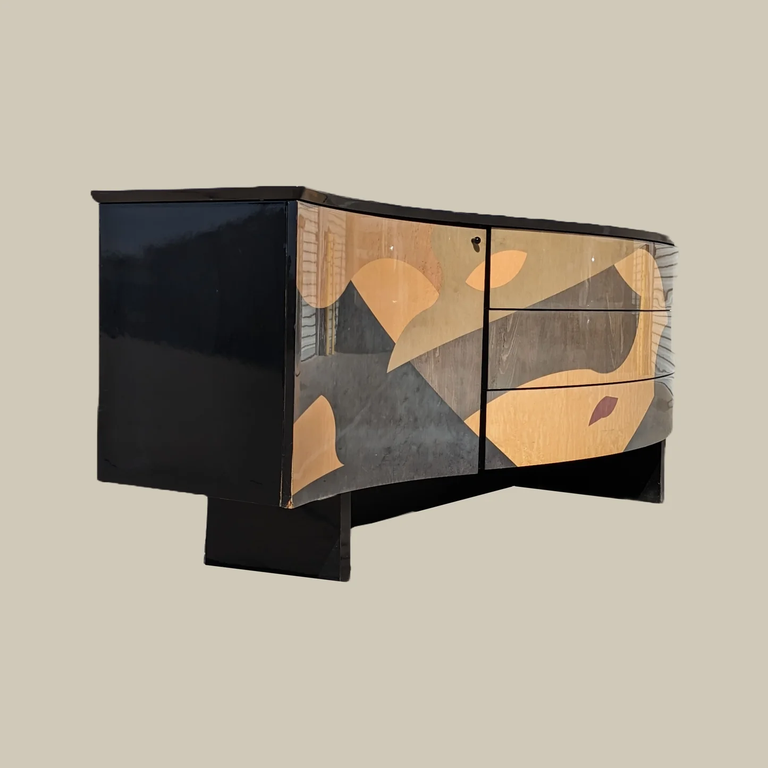


Generating CLIPSeg mask for: a dresser
CLIPSeg mask and overlay:


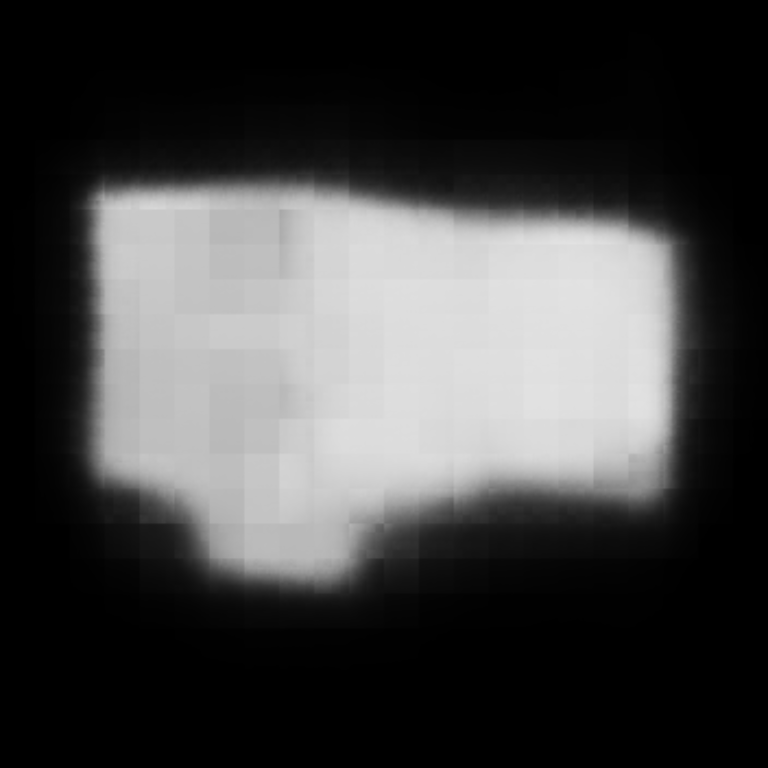

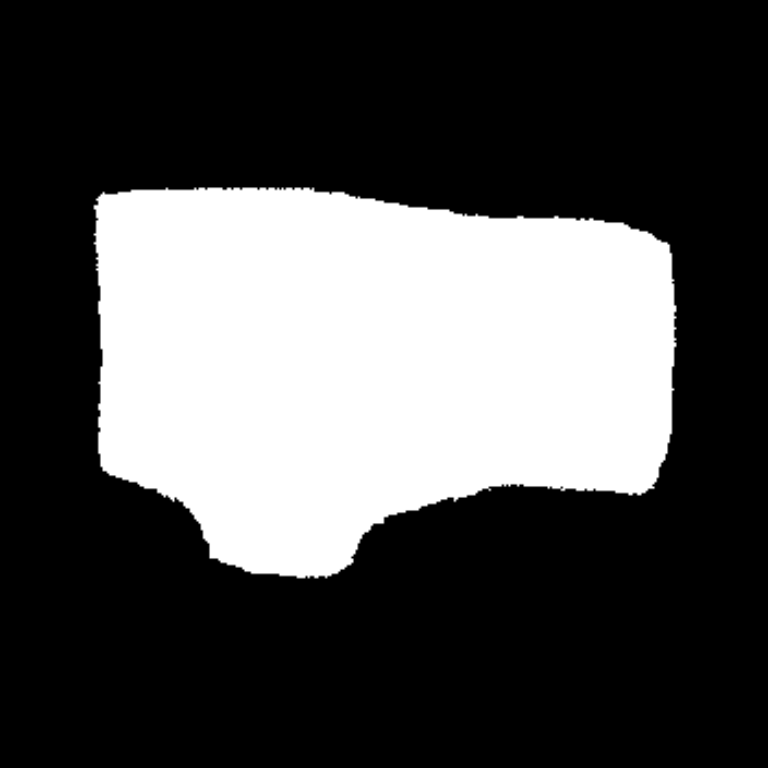

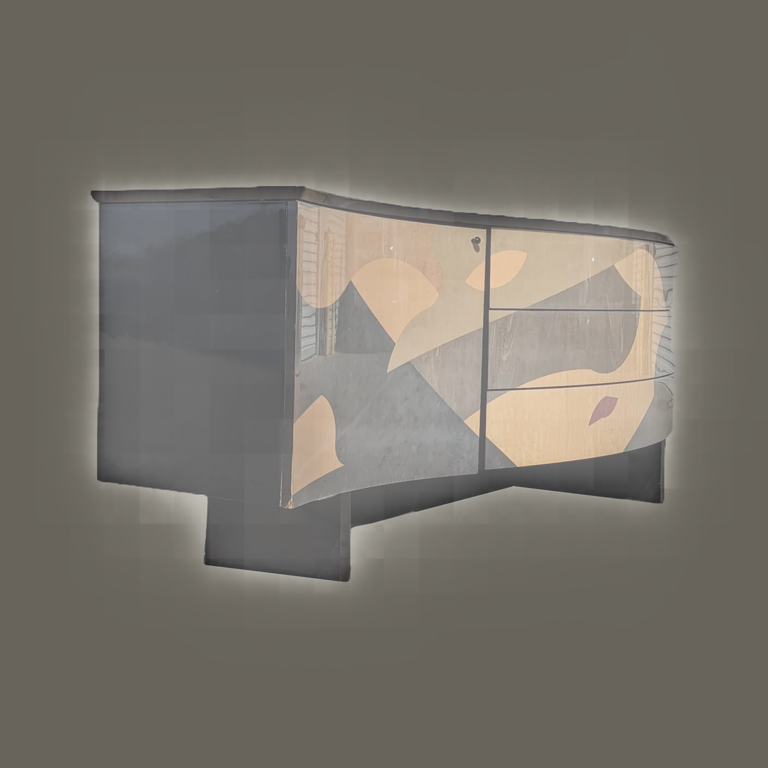

  Starting PGD attack...
    Iteration 1/200, Loss: 2408.6274
    Iteration 10/200, Loss: 1785.0740
    Iteration 20/200, Loss: 163.2778
    Iteration 30/200, Loss: -355.4712
    Iteration 40/200, Loss: -642.8445
    Iteration 50/200, Loss: -833.6440
    Iteration 60/200, Loss: -1014.6384
    Iteration 70/200, Loss: -1251.1243
    Iteration 80/200, Loss: -1490.5032
    Iteration 90/200, Loss: -1645.5486
    Iteration 100/200, Loss: -1764.6252
    Iteration 110/200, Loss: -1834.1067
    Iteration 120/200, Loss: -1890.7593
    Iteration 130/200, Loss: -1927.0901
    Iteration 140/200, Loss: -1966.0156
    Iteration 150/200, Loss: -1974.4170
    Iteration 160/200, Loss: -2000.3972
    Iteration 170/200, Loss: -2016.0728
    Iteration 180/200, Loss: -2027.3604
    Iteration 190/200, Loss: -2033.6704
    Iteration 200/200, Loss: -2051.6846

FARE Predictions:

Original Image:
  a photo of a dresser: 100.00%, a photo of a dog: 0.00%
Adversarial Image:
  a photo of a dresser: 0.23%, a photo of

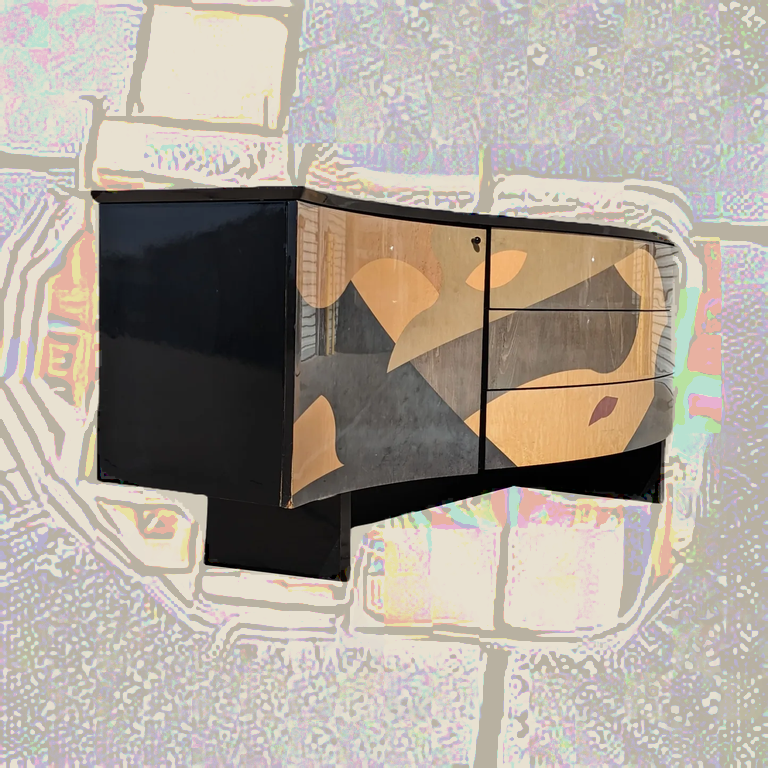

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# Install required libraries
!pip install -q transformers open_clip_torch torch torchvision Pillow ftfy regex tqdm

import torch
import torch.nn.functional as F
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, ToPILImage
import torchvision.transforms.functional as TF
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
import open_clip
import io
from google.colab import files
from IPython.display import display, clear_output

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# === Load CLIPSeg ===
clipseg_processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)

# === Load FARE CLIP model ===
def split_transforms(processor):
    pre_norm_transforms = []
    norm_params = None
    input_size = None
    for t in processor.transforms:
        if isinstance(t, Normalize):
            norm_params = {'mean': t.mean, 'std': t.std}
        else:
            if isinstance(t, Resize):
                input_size = t.size
            pre_norm_transforms.append(t)
    return Compose(pre_norm_transforms), norm_params, input_size

def load_fare_model():
    model_id = 'hf-hub:chs20/fare4-clip'
    model, _, transforms = open_clip.create_model_and_transforms(model_id)
    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    model.to(device).eval()
    pre_norm_processor, norm_params, input_size = split_transforms(transforms)
    return model, pre_norm_processor, norm_params, tokenizer, input_size

# === PGD Attack ===
def pgd_attack_masked(model, normalize_params, tokenizer, original_pil_image, original_text, adversary_text, mask_highres, model_input_size=224, epsilon=24/255, alpha=2/255, num_iter=50):
    x_orig = TF.to_tensor(original_pil_image).unsqueeze(0).to(device)
    x_adv = x_orig.clone().detach().requires_grad_(True)
    with torch.no_grad():
        text_features = model.encode_text(tokenizer([original_text, adversary_text]).to(device))

    print("  Starting PGD attack...")
    for i in range(num_iter):
        _, _, H, W = x_adv.shape
        scale_factor = model_input_size / min(H, W)
        x_resized = TF.resize(x_adv, size=[int(H * scale_factor), int(W * scale_factor)], interpolation=TF.InterpolationMode.BICUBIC)
        x_crop = TF.center_crop(x_resized, [model_input_size, model_input_size])
        x_model_input = TF.normalize(x_crop, mean=normalize_params['mean'], std=normalize_params['std'])
        image_features = model.encode_image(x_model_input)
        logits = image_features @ text_features.T * 100.0
        loss = logits[0, 0] - logits[0, 1]

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            grad_sign = x_adv.grad.sign()
            x_adv.data = x_adv.data - alpha * grad_sign
            eta = torch.clamp(x_adv.data - x_orig.data, min=-epsilon, max=epsilon)
            x_adv.data = torch.clamp(x_orig.data + eta * mask_highres, min=0, max=1)

        x_adv.grad.zero_()
        if (i+1) % 10 == 0 or i == 0 or i == num_iter - 1:
            print(f"    Iteration {i+1}/{num_iter}, Loss: {loss.item():.4f}")

    return x_adv.detach()

# === Similarity Scoring ===
def get_similarity_scores(model, pre_norm, norm_params, tokenizer, image_pil, text_options):
    x = pre_norm(image_pil).unsqueeze(0).to(device)
    x_norm = TF.normalize(x, mean=norm_params['mean'], std=norm_params['std'])
    with torch.no_grad():
        image_features = model.encode_image(x_norm)
        text_features = model.encode_text(tokenizer(text_options).to(device))
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        logits = 100.0 * (image_features @ text_features.T)
        probs = logits.softmax(dim=-1)
    return probs.cpu().numpy()

# === MAIN ===
print("Loading FARE model...")
model, pre_norm, norm_params, tokenizer, input_size = load_fare_model()
print("Model loaded.")

# === Upload ===
print("\nUpload your image:")
uploaded = files.upload()
image_bytes = next(iter(uploaded.values()), None)
image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
if max(image.size) > 768:
    image.thumbnail((768, 768), Image.Resampling.LANCZOS)
clear_output(wait=True)
print("Image uploaded:")
display(image)

# === Prompt setup ===
original_text = "a photo of a dresser"
adversary_text = "a photo of a dog"
foreground_prompt = "a dresser"

# === Step 1: CLIPSeg Mask ===
print("\nGenerating CLIPSeg mask for:", foreground_prompt)
inputs = clipseg_processor(text=[foreground_prompt], images=[image], return_tensors="pt").to(device)
with torch.no_grad():
    logits = clipseg_model(**inputs).logits
prob_map = logits.sigmoid()[0].cpu()
mask_binary = (prob_map > 0.5).float()

# === Step 2: Resize mask to match image ===
mask_resized = TF.resize(mask_binary.unsqueeze(0), size=image.size[::-1], interpolation=TF.InterpolationMode.BILINEAR)
prob_resized = TF.resize(prob_map.unsqueeze(0), size=image.size[::-1], interpolation=TF.InterpolationMode.BILINEAR)

# === Step 3: Visualize ===
print("CLIPSeg mask and overlay:")
display(TF.to_pil_image(prob_resized))
display(TF.to_pil_image(mask_resized))
overlay = TF.to_tensor(image) * 0.5 + prob_resized * 0.5
display(ToPILImage()(overlay.clamp(0, 1)))

# === Step 4: Prepare background mask for attack ===
background_mask = (1.0 - mask_resized).to(device)

# === Step 5: Masked Attack ===
adv_tensor = pgd_attack_masked(
    model, norm_params, tokenizer,
    image, original_text, adversary_text,
    mask_highres=background_mask,
    model_input_size=input_size,
    epsilon=24/255,
    alpha=2/255,
    num_iter=200
)
adv_image = ToPILImage()(adv_tensor.squeeze(0).cpu())

# === Step 6: Evaluation ===
print("\nFARE Predictions:")
orig_scores = get_similarity_scores(model, pre_norm, norm_params, tokenizer, image, [original_text, adversary_text])[0]
adv_scores = get_similarity_scores(model, pre_norm, norm_params, tokenizer, adv_image, [original_text, adversary_text])[0]

print(f"\nOriginal Image:\n  {original_text}: {orig_scores[0]:.2%}, {adversary_text}: {orig_scores[1]:.2%}")
print(f"Adversarial Image:\n  {original_text}: {adv_scores[0]:.2%}, {adversary_text}: {adv_scores[1]:.2%}")

# === Step 7: Display & Download ===
print("\nAdversarial Image (background attacked only):")
display(adv_image)

fname = "adversarial_clipseg_masked.png"
adv_image.save(fname)
files.download(fname)


### Conclusion: Findings on Attacking Google Lens and a Path Forward

After successfully generating two distinct adversarial images—one with a global, unmasked perturbation and another with a stealthy, background-only masked perturbation—the natural next step was to see if they could fool a real-world, black-box system. We chose Google Lens as the target. The results were not what we initially expected and proved to be incredibly insightful.

First, we tested the **unmasked image**, where the adversarial noise was spread across the entire picture. The result was an immediate success. When we presented this image to Google Lens, it was confidently misclassified as "a photo of a dog," exactly as we intended. This demonstrated that the attack was transferable; the adversarial features we crafted were robust enough to fool a completely different and highly sophisticated vision system.

Next, we tried the **masked image**. In this version, the foreground object—the dresser—was left completely untouched, and the adversarial perturbation was confined only to the background. Surprisingly, this attack failed. Google Lens correctly identified the object as a "dresser," seemingly ignoring the powerful adversarial signal we had embedded in the rest of the image.

This discrepancy led us to a hypothesis: Google Lens isn't just a simple classifier. It likely employs a multi-stage pipeline that starts with object detection. We reasoned that its system first identified the salient object (the clean dresser), drew a tight bounding box around it, and then fed only that cropped region to its classifier. The adversarial background, which held the entire attack, was effectively cropped out and never even analyzed.

To test this theory, we tried a simple trick. We took our masked adversarial image and zoomed out slightly, creating a natural padding or border around it. When we presented this "zoomed-out" version to Google Lens, its bounding box was forced to encompass the *entire* image—both the clean dresser and the adversarial background. Sure enough, the attack now worked perfectly. Google Lens was fooled.

This experiment reveals a critical lesson: to defeat a real-world system, you must often attack the entire pipeline, not just the final model. The masked model only failed because the pre-processing steps excluded what was likely a majority of the adversarial changes.

This points to a clear direction for future work. The next evolution of this attack should not just aim to fool a classifier. A more potent and robust approach would be to design an adversarial attack with a dual objective:
1.  Change the image's classification to the desired target.
2.  Simultaneously, manipulate the system's initial segmentation or object detection model.

The goal would be to use minimal perturbations to trick the bounding box model into expanding its region of interest to region that captures enough of the adversarial changes to effectively frustrate classification after application of localization and bounding. By forcing a given system to "see" enough of the picture, we can guarantee our adversarial payload is delivered to the classifier, bypassing the incident defense mechanism we observed. An attack that can manipulate a system’s fundamental perception of what to look at would be a significant step toward creating truly robust attacks against the complex vision systems deployed in the real world.